In [1]:
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
#import astropy.constants as C
import astropy.units as U
from astropy.convolution import Gaussian2DKernel
import galsim
from astropy.convolution import convolve_fft
from morphsed import Galaxy, AGN, star
from astropy.modeling.models import Sersic2D
from morphsed.plot import plotIFU
import morphsed.sed_interp as SEDs
import morphsed.emission_lines as ELs
from morphsed.math import Maskellipse
from morphsed import  sed_to_obse, coordinates_transfer, coordinates_transfer_inverse
import morphsed.images as Mimg
from morphsed.profiles import reshape_img
import time,csv,lmfit
from csst_slitless_calibration.IFUDisperser.disperser import MockSpectrum, IFUDisperser
U_SPEC_WAVE = U.erg/(U.s * U.cm**2 * U.AA)
from csst_slitless_calibration.utils import *
from csst_slitless_calibration.axeconf import aXeConfCSST, aXeConfHST
from csst_slitless_calibration.data import LINES, DATADIR
from csst_slitless_calibration.IFUDisperser.disperser import *
from csst_slitless_calibration.utils.cds9 import cDS9
from astropy.stats import sigma_clipped_stats
from astropy import units as u
from astropy.visualization.mpl_normalize import simple_norm
from astropy.cosmology import FlatLambdaCDM,z_at_value
from pathlib import Path
import sys
sys.path.append('/Users/liruancun/Works/accretion/')
sys.path.append('/Users/liruancun/Works/BH/')
sys.path.append('/Users/liruancun/Works/merger/')
import Constant as C

# Read flt file

In [41]:
targname = 'j024020m0126'
ra = 40.085471501
dec = -1.445221386
z = 0.026
ebv = 0.0282
cosmo = FlatLambdaCDM(H0=67.8 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.308)
d=cosmo.luminosity_distance(z)
dc=d.to(u.cm)
dis=dc.value
C_unit=1./(4*np.pi*dis**2)
filepath = '/Users/liruancun/Works/slitless/test/data/'

cutsize = 15.
cutsize_slt = [0.,40.,15.,15.]
cutp = [920, 1347, 712, 937]

# read slitless_s
hdu=fits.open(filepath+'ieel63aiq_flt.fits')
header0 = hdu['IIISMODEL_DIFF'].header
nyi = header0['NAXIS2']
nxi = header0['NAXIS1']
pads = header0['PAD']
nyi -= pads*2
nxi -= pads*2
ixmin0 = header0['IXMIN']
iymin0 = header0['IYMIN']
header0 = hdu['SCI'].header
filterslt = header0['FILTER']
header = hdu[0].header
im=Mimg.image(filename=filepath+'ieel63aiq_flt.fits',hdu=3)
imcut,cp=im.img_cut(ra,dec,cutsize,gain=1.,extime=1.)
transpar0 = im.coordinates_transfer_para.copy()
nys,nxs = imcut.shape
ixmin=cp[0]-pads
iymin=cp[2]-pads
wavelength=np.linspace( 7300., 12400, 400) # wavelength grid G102
tot_IFU = np.zeros((nys,nxs,len(wavelength)))
axeconf_file = Path('/Users/liruancun/Works/GitHub/slitless_calibration/csst_slitless_calibration/data/hst_conf/G102.F105W.V4.32.conf')
axeconf = aXeConfHST(axeconf_file)
idisperser = IFUDisperser(
  nx=nxi, ny=nyi,
  axeconf=axeconf,
  psf=None,
  pad=pads,
)
fiiibeams = idisperser.get_spec_orders(
  wave=wavelength, ifu=tot_IFU,
  ixmin=ixmin, iymin=iymin,
  beams=['A'],
  bin=5,
  psf=False,
  debug=False,
)
beam = fiiibeams['A']
cutp = [beam['x0'],beam['x1'],beam['y0'],beam['y1']]
imcut,cp=im.img_cut(ra,dec,cutsize_slt,cutposition=cutp,gain=1.,extime=1.)
maskcut = np.zeros_like(imcut,dtype=bool)
badvalue = imcut[47,233]
maskcut[imcut==badvalue] = True
maskcut = Maskellipse(maskcut,[450,68],160,0.87,0)
maskcut = Maskellipse(maskcut,[0.1,65],20,0.,0)
im.cut_mask_image=maskcut
im.set_psf_fwhm(fwhm=0.15)
im.gaussian_psf()

hdu=fits.open(filepath+'j024020m0126-f105w_drz_sci.fits')
header = hdu[0].header
im2=Mimg.image(filename=filepath+'j024020m0126-f105w_drz_sci.fits',hdu=0)
imcut,cp=im2.img_cut(ra,dec,cutsize,gain=1.,extime=1.)
maskcut = np.zeros_like(imcut,dtype=bool)
im2.cut_mask_image=maskcut
psf = fits.open(filepath+'psfs/j024020m0126-f105w_psf.fits')
im2.PSF = psf[1].data
eps_to_phyflux2 = C_unit/(header['PHOTFLAM'])

hdu=fits.open(filepath+'j024020m0126-f140w_drz_sci.fits')
header = hdu[0].header
im3=Mimg.image(filename=filepath+'j024020m0126-f140w_drz_sci.fits',hdu=0)
imcut,cp=im3.img_cut(ra,dec,cutsize,gain=1.,extime=1.)
maskcut = np.zeros_like(imcut,dtype=bool)
im3.cut_mask_image=maskcut
psf = fits.open(filepath+'psfs/j024020m0126-f140w_psf.fits')
im3.PSF = psf[1].data
eps_to_phyflux3 = C_unit/(header['PHOTFLAM'])




In [59]:
par_total = lmfit.Parameters()
par_total.add('logM', 10.74 , min=8., max=13.)
sesicparam = ['x', 'y', 'Re', 'n', 'ang', 'axrat']
par_total.add('BoT', value=0.3, min=0.05, max=0.95)
par_total.add('sersic1_x', value=0, min=-0.5, max=0.5)
par_total.add('sersic1_y', value=0, min=-0.5, max=0.5)
par_total.add('sersic1_Re', value=0.5, min=0.1, max=15)
par_total.add('sersic1_n', value=3., min=1., max=6.)
par_total.add('sersic1_ang', value=0., min=-90., max=90.,vary=False)
par_total.add('sersic1_axrat', value=1, min=0.2, max=1.,vary=False)
par_total.add('sersic1_f_cont', value=0.5, min=0., max=1.)
par_total.add('sersic1_age', value=5., min=0.1, max=13.)
par_total.add('sersic1_Z', value=0.02, min=0.001, max=0.04,vary=False)
par_total.add('sersic1_Av', value=0.7, min =0.3, max=5.1)
par_total.add('sersic2_x', expr='1.*sersic1_x')
par_total.add('sersic2_y', expr='1.*sersic1_y')
#par_total.add('sersic2_x', value=0.1, min=-4., max=4)
#par_total.add('sersic2_y', value=-0.1, min=-4., max=4)
par_total.add('sersic2_Re', value=10., min=3., max=45.)
par_total.add('sersic2_n', value=1., vary=False)
par_total.add('sersic2_ang', value=-20., min=-90., max=90.)
par_total.add('sersic2_axrat', value=0.8, min=0.2, max=1.)
par_total.add('sersic2_f_cont', value=0.5, min=0., max=1.)
#par_total.add('sersic2_f_cont_k', value=0.0, min=-1, max=1)
#par_total.add('sersic2_f_cont_b', value=0.5, min=0., max=1.)

par_total.add('sersic2_age', value=1., min=0.1, max=13.)
par_total.add('sersic2_Z', value=0.02, min=0.001, max=0.04,vary=False)
par_total.add('sersic2_Av', value=0.7, min =0.3, max=5.1)
sm = 0
par_total.add('sky_sls', value=sm, min =sm-0.5, max=sm+0.5,vary=True)
par_total.add('sky_2', value=sm, min =sm-0.5, max=sm+0.5,vary=True)
par_total.add('sky_3', value=sm, min =sm-0.5, max=sm+0.5,vary=True)

par_total.add('sn_x', value=0, min=-0.3, max=0.3)
par_total.add('sn_y', value=0, min=-0.3, max=0.3)
par_total.add('sn_Teff', value=6000., min=2000., max=20000.)
par_total.add('sn_dis', value=100000., min=1e-2,max=1e6)

par_total.add('star1_x', value = -0.8845, min = -0.8845-0.18, max = -0.8845+0.18)
par_total.add('star1_y', value = -6.1015, min = -6.1015-0.18, max = -6.1015+0.18)
par_total.add('star1_Teff', value=5000., min=2000., max=20000.)
par_total.add('star1_dis', value=100000., min=1e-2,max=1e6)

par_total.add('star2_x', value = -0.5244, min = -0.5244-0.18, max = -0.5244+0.18)
par_total.add('star2_y', value = -10.5055, min = -10.5055-0.18, max = -10.5055+0.18)
par_total.add('star2_Teff', value=5000., min=2000., max=20000.)
par_total.add('star2_dis', value=100000., min=1e-2,max=1e6)

par_total.add('ifu_xs', value=0, min=-3, max=3)
par_total.add('ifu_ys', value=0, min=-3, max=3)


In [40]:
transpar0

{'x0': 110.605395563956,
 'x0shift': 0.0,
 'y0': 110.7234918587975,
 'y0shift': 0.0,
 'dxra': -0.18006631931381206,
 'dxdec': -7.377711346892414,
 'dyra': -8.38306642044425,
 'dydec': 0.23201220418717033,
 'pixsc': 0.13541361770815172,
 'delta_ang': 1.8012280347752532}

In [47]:

import re


sedloopmap = np.zeros((nys,nxs))
sedloopmap = sedloopmap.astype(int)
def residualcon(parc):
    strucure_para1 = {'xcen': parc['sersic1_x'].value, 'ycen': parc['sersic1_y'].value,
                     'frac': 100.*parc['BoT'], 're': parc['sersic1_Re'].value, 'nser': parc['sersic1_n'].value,
                     'ang': parc['sersic1_ang'].value, 'axrat': parc['sersic1_axrat'].value, 'box': 0.0, 'convolve': False}
    age1 = {'type': "const", 'paradic':{'value': parc['sersic1_age'].value}}
    Z1 = {'type': "const", 'paradic':{'value':  parc['sersic1_Z'].value}}
    f_cont1 = {'type': "const", 'paradic':{'value': parc['sersic1_f_cont'].value}}
    Av1 = {'type': "const", 'paradic':{'value': parc['sersic1_Av'].value}}
    strucure_para2 = {'xcen': parc['sersic2_x'].value, 'ycen': parc['sersic2_y'].value,
                     'frac': 100.*(1.-parc['BoT']), 're': parc['sersic2_Re'].value, 'nser': parc['sersic2_n'].value,
                     'ang': parc['sersic2_ang'].value, 'axrat': parc['sersic2_axrat'].value, 'box': 0.0, 'convolve': False}
    age2 = {'type': "const", 'paradic':{'value': parc['sersic2_age'].value}}
    f_cont2 = {'type': "const", 'paradic':{'value': parc['sersic2_f_cont'].value}}
    Z2 = {'type': "const", 'paradic':{'value':  parc['sersic2_Z'].value}}
    Av2 = {'type': "const", 'paradic':{'value': parc['sersic2_Av'].value}}
    residual_image=[]

    ny,nx = im2.cut_image.shape        
    Mygalaxy = Galaxy(mass = 10**parc['logM'].value, z=z, ebv_G=ebv)
    Mygalaxy.add_subC('sersic',strucure_para1,age1,Z1,f_cont1,Av1)
    Mygalaxy.add_subC('sersic',strucure_para2,age2,Z2,f_cont2,Av2)
    totalmass,apertures = Mygalaxy.generate_mass_map((ny,nx),np.array(im.PSF),transpar=im2.coordinates_transfer_para)
    star1 = star(parc['star1_x'].value, parc['star1_y'].value, parc['star1_Teff'].value, parc['star1_dis'].value)
    star2 = star(parc['star2_x'].value, parc['star2_y'].value, parc['star2_Teff'].value, parc['star2_dis'].value)
    sn = star(parc['sn_x'].value, parc['sn_y'].value, parc['sn_Teff'].value, parc['sn_dis'].value)
    
    imm2 = Mygalaxy.generate_image('wfc3_f105w',im2.PSF)
    imm2 += star1.generate_image([ny,nx], 'wfc3_f105w', im2.PSF, {'xcen':50, 'ycen':50},transpar=im2.coordinates_transfer_para)/C_unit
    imm2 += star2.generate_image([ny,nx], 'wfc3_f105w', im2.PSF, {'xcen':50, 'ycen':50},transpar=im2.coordinates_transfer_para)/C_unit
    imm2 += sn.generate_image([ny,nx], 'wfc3_f105w', im2.PSF, {'xcen':50, 'ycen':50},transpar=im2.coordinates_transfer_para)/C_unit
    imm2 *= eps_to_phyflux2 
    imm2 += np.ones_like(imm2)*parc['sky_2'].value
    residual_image.append((im2.cut_image-imm2)/im2.cut_sigma_image)

    imm3 = Mygalaxy.generate_image('wfc3_f140w',im3.PSF)
    imm3 += star1.generate_image([ny,nx], 'wfc3_f140w', im3.PSF, {'xcen':50, 'ycen':50},transpar=im3.coordinates_transfer_para)/C_unit
    imm3 += star2.generate_image([ny,nx], 'wfc3_f140w', im3.PSF, {'xcen':50, 'ycen':50},transpar=im3.coordinates_transfer_para)/C_unit
    imm3 += sn.generate_image([ny,nx], 'wfc3_f140w', im3.PSF, {'xcen':50, 'ycen':50},transpar=im3.coordinates_transfer_para)/C_unit
    imm3 *= eps_to_phyflux3 
    imm3 += np.ones_like(imm3)*parc['sky_3'].value
    residual_image.append((im3.cut_image-imm3)/im3.cut_sigma_image)

    transpar0['x0shift'] = parc['ifu_xs'].value
    transpar0['y0shift'] = parc['ifu_ys'].value
    totalmass,apertures = Mygalaxy.generate_mass_map((nys,nxs),np.array(im.PSF),transpar=transpar0)
    IFU = Mygalaxy.generate_SED_IFU(wavelength,resolution=10,sedloopmap=sedloopmap)*C_unit
    IFU += star1.generate_SED_IFU([nys,nxs], wavelength, im.PSF, {'xcen':50, 'ycen':50},transpar=transpar0)
    IFU += star2.generate_SED_IFU([nys,nxs], wavelength, im.PSF, {'xcen':50, 'ycen':50},transpar=transpar0)
    IFU += sn.generate_SED_IFU([nys,nxs], wavelength, im.PSF, {'xcen':50, 'ycen':50},transpar=transpar0)
    fiiibeams = idisperser.get_spec_orders(
    wave=wavelength, ifu=IFU,
    ixmin=ixmin, iymin=iymin,
    beams=['A'],
    bin=5,
    psf=False,
    debug=False,
    )
    modelsls = fiiibeams['A']['beam']
    modelsls += np.ones_like(modelsls)*parc['sky_sls'].value
    resi = (im.cut_image-modelsls)/im.cut_sigma_image
    residual_image.append(resi[~im.cut_mask_image])

    residu_flat = residual_image[0].ravel()
    residu_flat=np.append(residu_flat,residual_image[1].ravel())
    residu_flat=np.append(residu_flat,residual_image[2])


    del (Mygalaxy)
    return residu_flat


In [63]:
fitresult = lmfit.minimize(residualcon,par_total,nan_policy='omit' )
par_total = fitresult.params

In [64]:
fitresult


In [62]:


with open(filepath+"/bestpar_slitless.csv", mode='r') as infile:
    reader = csv.reader(infile)
    with open(filepath+"/fake.csv", mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict = dict((rows[0],float(rows[1])) for rows in reader)
ckey=par_total.keys()
for cc in ckey:
    try:
        par_total[cc].set(float(mydict[cc]))
    except KeyError:
        a= 1


In [66]:

bestpar = par_total.valuesdict()

strucure_para1 = {'xcen': par_total['sersic1_x'].value, 'ycen': par_total['sersic1_y'].value,
                'frac': 100.*par_total['BoT'], 're': par_total['sersic1_Re'].value, 'nser': par_total['sersic1_n'].value,
                'ang': par_total['sersic1_ang'].value, 'axrat': par_total['sersic1_axrat'].value, 'box': 0.0, 'convolve': False}
age1 = {'type': "const", 'paradic':{'value': par_total['sersic1_age'].value}}
Z1 = {'type': "const", 'paradic':{'value':  par_total['sersic1_Z'].value}}
f_cont1 = {'type': "const", 'paradic':{'value': par_total['sersic1_f_cont'].value}}
Av1 = {'type': "const", 'paradic':{'value': par_total['sersic1_Av'].value}}
strucure_para2 = {'xcen': par_total['sersic2_x'].value, 'ycen': par_total['sersic2_y'].value,
                'frac': 100.*(1.-par_total['BoT']), 're': par_total['sersic2_Re'].value, 'nser': par_total['sersic2_n'].value,
                'ang': par_total['sersic2_ang'].value, 'axrat': par_total['sersic2_axrat'].value, 'box': 0.0, 'convolve': False}
age2 = {'type': "const", 'paradic':{'value': par_total['sersic2_age'].value}}
f_cont2 = {'type': "const", 'paradic':{'value': par_total['sersic2_f_cont'].value}}
Z2 = {'type': "const", 'paradic':{'value':  par_total['sersic2_Z'].value}}
Av2 = {'type': "const", 'paradic':{'value': par_total['sersic2_Av'].value}}

imagecuts = []
model_image = []
residual_image=[]

ny,nx = im2.cut_image.shape        
Mygalaxy = Galaxy(mass = 10**par_total['logM'].value, z=z, ebv_G=ebv)
Mygalaxy.add_subC('sersic',strucure_para1,age1,Z1,f_cont1,Av1)
Mygalaxy.add_subC('sersic',strucure_para2,age2,Z2,f_cont2,Av2)
totalmass,apertures = Mygalaxy.generate_mass_map((ny,nx),np.array(im.PSF),transpar=im2.coordinates_transfer_para)
star1 = star(par_total['star1_x'].value, par_total['star1_y'].value, par_total['star1_Teff'].value, par_total['star1_dis'].value)
star2 = star(par_total['star2_x'].value, par_total['star2_y'].value, par_total['star2_Teff'].value, par_total['star2_dis'].value)

imm2 = Mygalaxy.generate_image('wfc3_f105w',im2.PSF)
imm2 += star1.generate_image([ny,nx], 'wfc3_f105w', im2.PSF, {'xcen':50, 'ycen':50},transpar=im2.coordinates_transfer_para)/C_unit
imm2 += star2.generate_image([ny,nx], 'wfc3_f105w', im2.PSF, {'xcen':50, 'ycen':50},transpar=im2.coordinates_transfer_para)/C_unit
imm2 *= eps_to_phyflux2 
imm2 += np.ones_like(imm2)*par_total['sky_2'].value
imagecuts.append(im2.cut_image)
model_image.append(imm2)
residual_image.append((im2.cut_image-imm2))

imm3 = Mygalaxy.generate_image('wfc3_f140w',im3.PSF)
imm3 += star1.generate_image([ny,nx], 'wfc3_f140w', im3.PSF, {'xcen':50, 'ycen':50},transpar=im3.coordinates_transfer_para)/C_unit
imm3 += star2.generate_image([ny,nx], 'wfc3_f140w', im3.PSF, {'xcen':50, 'ycen':50},transpar=im3.coordinates_transfer_para)/C_unit
imm3 *= eps_to_phyflux3 
imm3 += np.ones_like(imm3)*par_total['sky_3'].value
imagecuts.append(im3.cut_image)
model_image.append(imm3)
residual_image.append((im3.cut_image-imm3))

transpar0['x0shift'] = par_total['ifu_xs'].value
transpar0['y0shift'] = par_total['ifu_ys'].value
totalmass,apertures = Mygalaxy.generate_mass_map((nys,nxs),np.array(im.PSF),transpar=transpar0)
IFU = Mygalaxy.generate_SED_IFU(wavelength,resolution=10,sedloopmap=sedloopmap)*C_unit
IFU += star1.generate_SED_IFU([nys,nxs], wavelength, im.PSF, {'xcen':50, 'ycen':50},transpar=transpar0)
IFU += star2.generate_SED_IFU([nys,nxs], wavelength, im.PSF, {'xcen':50, 'ycen':50},transpar=transpar0)
fiiibeams = idisperser.get_spec_orders(
wave=wavelength, ifu=IFU,
ixmin=ixmin, iymin=iymin,
beams=['A'],
bin=5,
psf=False,
debug=False,
)
modelsls = fiiibeams['A']['beam']

    

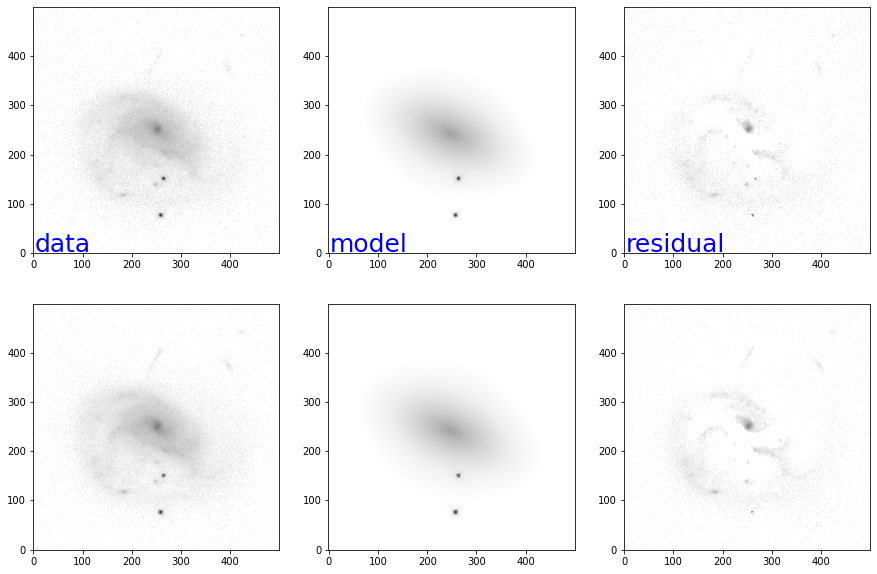

In [67]:


data_all = [imagecuts,model_image,residual_image]
shape=[ny,nx]
nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10),squeeze=True)
ax = ax.ravel()
fignumber=15
for i in range(nrows):
    sky_mean, sky_median, sky_std = sigma_clipped_stats(data_all[0][i], sigma=3.0, maxiters=5)
    norm = simple_norm([0.5*sky_std, 3*np.max(data_all[1][i])], 'log', percent=100)
    for j in range(ncols):
        ax[3*i+j].imshow(data_all[j][i], cmap='Greys', origin='lower', norm=norm,
                           interpolation='nearest')
    ny,nx = data_all[0][i].shape
    #ax[3*i+0].text(3,0.85*ny, ""), size = 25, color = 'r', weight = "light" )
ax[0].text(3,3, "data", size = 25, color = 'b', weight = "light" )
ax[1].text(3,3, "model", size = 25, color = 'b', weight = "light" )
ax[2].text(3,3, "residual", size = 25, color = 'b', weight = "light" )
#plt.savefig(filepath+'multifit_withspec.png',dpi=200.,bbox_inches='tight')
plt.show()


In [65]:
w = csv.writer(open(filepath+"/bestpar_slitlessfit.csv", "w"))
for key, val in bestpar.items():
    w.writerow([key, val])
w = csv.writer(open(filepath+"/fake.csv", "w"))

In [30]:

wavelength=np.linspace( 9600., 18000, 1001) # wavelength grid G140
wavelength=np.linspace( 7300., 12400, 1001) # wavelength grid G102
start_t = time.time()
totalmass,apertures = Mygalaxy.generate_mass_map((nys,nxs),np.array(im.PSF),transpar=transpar0)
IFU = Mygalaxy.generate_SED_IFU(wavelength,resolution=10,sedloopmap=sedloopmap)*C_unit
IFU += star1.generate_SED_IFU([nys,nxs], wavelength, im.PSF, {'xcen':50, 'ycen':50},transpar=transpar0)
IFU += star2.generate_SED_IFU([nys,nxs], wavelength, im.PSF, {'xcen':50, 'ycen':50},transpar=transpar0)
stop_t = time.time()
print ("elapse time {0:.2f} s".format(stop_t-start_t))

elapse time 1.12 s


In [9]:
axeconf_file = Path('/Users/liruancun/Works/GitHub/slitless_calibration/csst_slitless_calibration/data/hst_conf/G141.F105W.V4.32.conf')
axeconf = aXeConfHST(axeconf_file)
idisperser = IFUDisperser(
  nx=nxi, ny=nyi,
  axeconf=axeconf,
  psf=None,
  pad=pads, 
)


In [34]:
fiiibeams = idisperser.get_spec_orders(
  wave=wavelength, ifu=IFU,
  ixmin=ixmin, iymin=iymin,
  beams=['A'],
  bin=5,
  psf=False,
  debug=False,
)
modelsls = fiiibeams['A']['beam']

In [39]:
fiiibeams = idisperser.get_spec_orders(
  wave=wavelength, ifu=IFU,
  ixmin=ixmin, iymin=iymin,
  beams=['A'],
  bin=5,
  psf=False,
  debug=False,
)
beam = fiiibeams['A']
cutp = [beam['x0'],beam['x1'],beam['y0'],beam['y1']]
fiiigrism = idisperser.beam2image(fiiibeams)
#fiiigrism = fiiigrism * factor

{'ok': True,
 'beam': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'x0': 920,
 'x1': 1347,
 'y0': 712,
 'y1': 937,
 'ny_origin': 225,
 'nx_origin': 427,
 'ymin': 712,
 'xmin': 920,
 'ymin_origin': 456,
 'xmin_origin': 664,
 'origin_beam_size': (225, 427),
 'overflow_x_min': False,
 'overflow_x_max': False,
 'overflow_y_min': False,
 'overflow_y_max': False,
 'stamp_nx': 220,
 'stamp_ny': 220,
 'pad': 256,
 'xcenter': 732.5,
 'ycenter': 566.5}

In [35]:
fiiibeams['A']['beam'].shape

(225, 427)

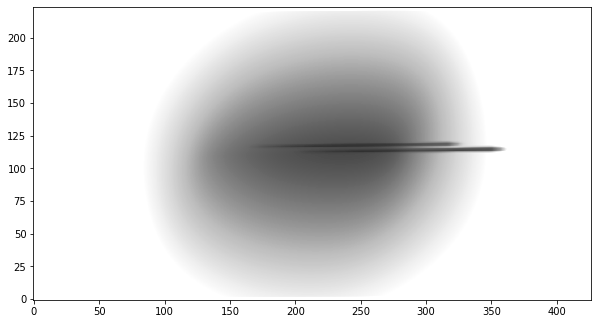

In [35]:
fig = plt.figure(figsize=(10, 7))
datap = modelsls
sky_mean, sky_median, sky_std = sigma_clipped_stats(datap, sigma=3.0, maxiters=5)
norm = simple_norm([0.5*sky_std, 3*np.max(datap)], 'log', percent=100)
plt.imshow(datap, cmap='Greys', origin='lower', norm=norm)
#plt.imshow(im.cut_mask_image.astype(float), cmap='Blues', origin='lower', alpha=0.5)
#plt.savefig('/Users/liruancun/Desktop/exp.png',dpi=200,bbox_inches='tight')
plt.show()

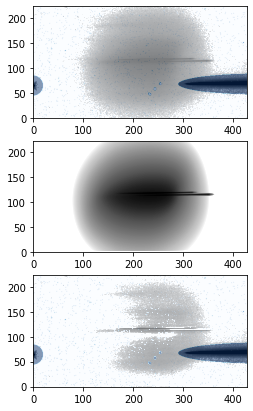

In [68]:
fig = plt.figure(figsize=(30, 7))
datap = im.cut_image-modelsls
sky_mean, sky_median, sky_std = sigma_clipped_stats(datap, sigma=3.0, maxiters=5)
norm = simple_norm([0.5*sky_std, 0.03*np.max(datap)], 'log', percent=100)
plt.subplot(3,1,1)
datap = im.cut_image
plt.imshow(datap, cmap='Greys', origin='lower', norm=norm)
plt.imshow(im.cut_mask_image.astype(float), cmap='Blues', origin='lower', alpha=0.5)
plt.subplot(3,1,2)
datap = modelsls
plt.imshow(datap, cmap='Greys', origin='lower', norm=norm)
#plt.imshow(im.cut_mask_image.astype(float), cmap='Blues', origin='lower', alpha=0.5)
plt.subplot(3,1,3)
datap = im.cut_image-modelsls
plt.imshow(datap, cmap='Greys', origin='lower', norm=norm)
plt.imshow(im.cut_mask_image.astype(float), cmap='Blues', origin='lower', alpha=0.5)
plt.savefig('/Users/liruancun/Desktop/exp.png',dpi=200,bbox_inches='tight')
plt.show()

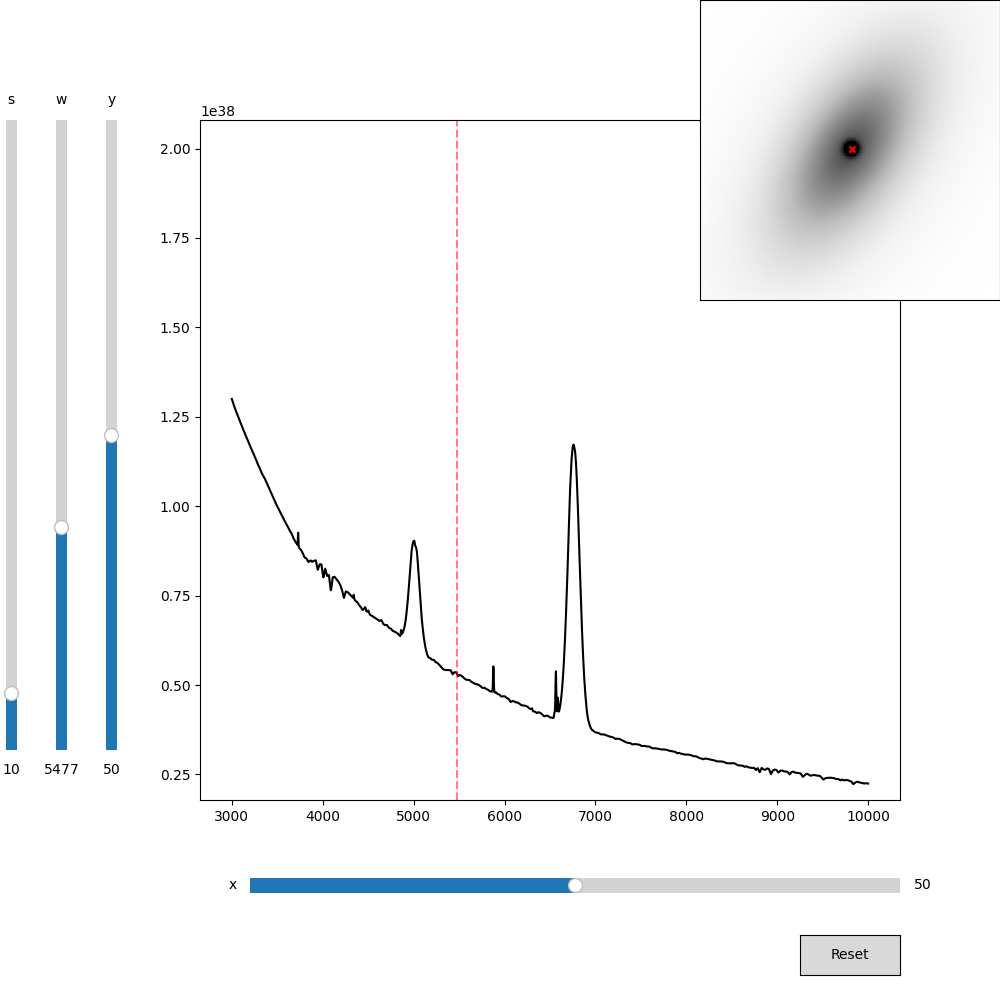

In [9]:
fig = plotIFU(wavelength,IFU_cov)
plt.show(block=False)

In [10]:
# init IFUDisperser
disperser = IFUDisperser(
  nx=nxi, ny=nyi,
  axeconf=AXECONF,
  aper=aper,
  psf=psf_image
)

Exception: unknown band type: G141.F105W.V4.32.conf

In [53]:
axeconf.

<bound method aXeConfBase.fit_wave of <csst_slitless_calibration.axeconf.aXeConfHST object at 0x7f9d222ea2d0>>

In [51]:
axeconf_file = Path('/Users/liruancun/Works/GitHub/slitless_calibration/csst_slitless_calibration/data/hst_conf/G141.F105W.V4.32.conf')
axeconf = aXeConfHST(axeconf_file)

In [11]:
#factor = 1  / beam.PAM_value

#wave = flt.object_dispersers[bid][1][0].astype(np.float64) * U.AA
#spec = flt.object_dispersers[bid][1][1].astype(np.float64) * U_SPEC_WAVE
#this_spec_table = Table({'WAVELENGTH': wave, 'FLUX': spec})
#header = fits.Header({'OBJECT': result['simbad_name'] + '|' + str(result['mast_target']) + f'-{bid}', 'EXTNAME': f'SPEC1D_{bid}'})
#spec_hdu = fits.BinTableHDU(this_spec_table, header=header)
#spec_hdus.append(spec_hdu)

#pad = beam.pad

axeconf_file = Path('/Users/liruancun/Works/GitHub/slitless_calibration/csst_slitless_calibration/data/hst_conf/G141.F105W.V4.32.conf')
axeconf = aXeConfHST(axeconf_file)
nyi, nxi = flt.seg.shape
nyi -= pad*2
nxi -= pad*2
idisperser = IFUDisperser(
  nx=nxi, ny=nyi,
  axeconf=axeconf,
  psf=None,
  pad=pad,
)
xc=(beam.xc+beam.xcenter-beam.pad)/beam.grow
yc=(beam.yc+beam.ycenter-beam.pad)/beam.grow

iymin = sdirect_y.start - pad
ixmin = sdirect_x.start - pad

nys, nxs = beam.direct.shape

# image method
simage = beam.direct.copy()
simage_mask = beam.seg == bid
simage[~simage_mask] = 0
stamp = simage / simage.sum() # stamp is always normalized
print(f'==> {flt_index}:{band} {bid} {bname} stamp max:{stamp.max()}, spec_max:{this_spec_table["FLUX"].max()}')
just_use_grizli_result = False
if this_spec_table["FLUX"].max()>1:
  just_use_grizli_result = True
  print(f'bad spectrum for {bid}, just use old result')
fibeams = idisperser.get_spec_orders_with_fixed_image(
  stamp=stamp, spec=this_spec_table,
  xc=xc, yc=yc,
  ixmin=ixmin, iymin=iymin,
  psf=False,
)
figrism = idisperser.beam2image(fibeams)
figrism = figrism * factor
if just_use_grizli_result:
  our_ibeam_model_data += this_beam_model_data
else:
  our_ibeam_model_data += figrism
# debugi_bid['fibeams'] = fibeams
# debugi_bid['figrism'] = figrism

# image => ifu data, but calculate dispersion functions at single position
print(f'doing {flt_index} {bid} {bname} image_ifu...')
fiibeams = idisperser.get_spec_orders_with_fixed_image_with_ifu(
  stamp=stamp, spec=this_spec_table, seg=simage_mask,
  ixmin=ixmin, iymin=iymin,
  xc=xc, yc=yc,
  psf=False,
)
fiigrism = idisperser.beam2image(fiibeams)
fiigrism = fiigrism * factor
our_iibeam_model_data += fiigrism
# debugi_bid['fiibeams'] = fiibeams
# debugi_bid['fiigrism'] = fiigrism


# full ifu method
print(f'doing {flt_index} {bid} {bname} ifu...')
if 'make ifu data':
  _flux_x = this_spec_table['WAVELENGTH'].data
  _flux_y = this_spec_table['FLUX'].data

  _stamp = stamp.copy()
  stamp_reshaped = _stamp.reshape((nys, nxs, 1))
  ifu_flux = _flux_y * stamp_reshaped

fiiibeams = idisperser.get_spec_orders(
  wave=_flux_x, ifu=ifu_flux, seg=simage_mask,
  ixmin=ixmin, iymin=iymin,
  bin=5,
  psf=False,
  debug=True,
)
fiiigrism = idisperser.beam2image(fiiibeams)
fiiigrism = fiiigrism * factor
our_iiibeam_model_data += fiiigrism

Exception: unknown band type: G141.F105W.V4.32.conf

In [26]:
for i in range(3):
    t0 = time.time()
    beams = disperser.get_spec_orders(
        wave=wavelength,
        ifu=IFU,
        ixmin=ixmin, iymin=iymin,
        exptime=exptime,
        psf=True,
        bin=3,
        debug=True,
        beams=['A']
    )
    print(f'calculate beams at {i} times in {time.time()-t0:.2f}s')

calculating dxdylam 3d for ((3950, 3950))+(100,100):3:A:3000.0:10000.0
	 in 5.37s
  prepare A in 5.37s
calculate A in 5.37s + 0.13s
calculate beams at 0 times in 5.51s
  prepare A in 0.00s
calculate A in 0.00s + 0.13s
calculate beams at 1 times in 0.14s
  prepare A in 0.00s
calculate A in 0.00s + 0.14s
calculate beams at 2 times in 0.14s


In [91]:
Mygalaxy.redshift

0.03

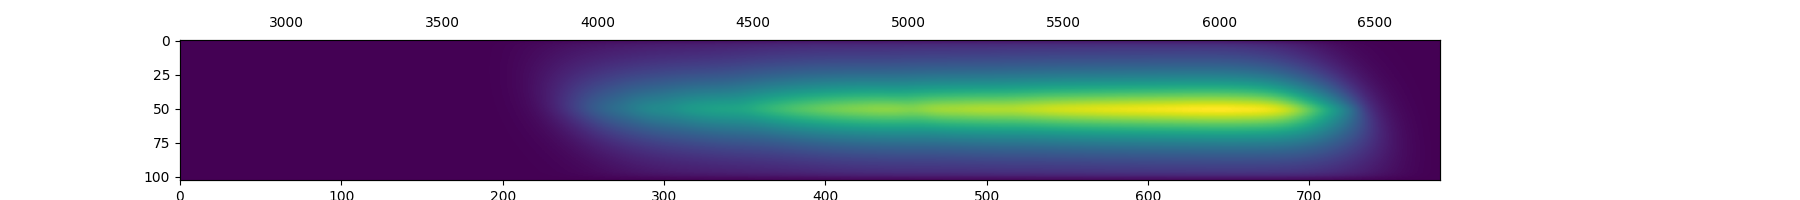

In [27]:
grism_image = beams['A']['beam']
if 'show grism beam':
    fig = plt.figure(figsize=(18,2))
        
    ax1 = fig.add_axes([0.1,0.1, 0.7, 0.7])
    ax1.xaxis.set_tick_params(labeltop=True)
    ax1.xaxis.set_tick_params(labelbottom=False)
    ax1.xaxis.set_tick_params(bottom=False)
    ax1.yaxis.set_tick_params(labelleft=False)
    ax1.yaxis.set_tick_params(left=False)
    xmin = beams['A']['debug']['xmin']
    xmax = beams['A']['debug']['xmax']
    lam_min = beams['A']['debug']['lam'][0]
    lam_max = beams['A']['debug']['lam'][-1]
    trans_func = lambda _: (_-xmin)/(xmax-xmin) * (lam_max-lam_min) + lam_min
    ax1.set_xlim(trans_func(0), trans_func(grism_image.shape[1]-1))

    ax = fig.add_axes([0.1,0.1, 0.7, 0.7])
    ax.imshow(grism_image, aspect='auto')
    ax.set_xlim(0, grism_image.shape[1]-1)
plt.savefig('./slitless.png',dpi=200,bbox_inches='tight')
plt.show(block=False)
time.sleep(2)


In [39]:
s1 = np.pi*1**2*1e-6
s2 = np.pi*0.5**2*1e-6
I = 12
print (I/s1,I/s2,7.5/12*5)

3819718.6342054885 15278874.536821954 3.125
